In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from scipy.stats import itemfreq
import networkx as nx
import pandas as pd

import matplotlib
import seaborn as sns
sns.set_palette('colorblind')
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10, 8]

matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['xtick.major.size'] = 9
matplotlib.rcParams['ytick.major.size'] = 9
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['ytick.minor.size'] = 4

matplotlib.rcParams['axes.linewidth'] = 2

matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['xtick.minor.width'] = 2
matplotlib.rcParams['ytick.minor.width'] = 2

matplotlib.rcParams['text.usetex'] = True
import random

from toysimulations import Network

import pickle

In [3]:
INS_DATA_COLUMNS = ['time', 'stoplist_len', 'stoplist_volume', 'rest_stoplist_volume',
                    'pickup_idx', 'dropoff_idx', 'insertion_type', 'pickup_enroute',
                    'dropoff_enroute']

## load data for streetnetworks

In [4]:
results = dict()

for coarse_graining_meters, target_edge_length in [
                                                   (200, 400),
                                                   (200, 600),
                                                   (200, 800)
                                                  ]:
    pickle_file = f"../data/street_berlin_homogenized_coarse_graining_meters_{coarse_graining_meters}"\
                  f"_target_edge_length_{target_edge_length}.pkl"
    
    with open(pickle_file, 'rb') as f:
        results[(coarse_graining_meters, target_edge_length)] = pickle.load(f)

In [5]:
graph_path = '../data/homogenized_networks/berlin/'

with open(f"{graph_path}/diff_coarse_graining/all_berlin.pkl", 'rb') as f:
    all_Gs = pickle.load(f)

In [6]:
def draw_network(K, ax=None, title="A streetnetwork", node_color=None):
    if ax is None:
        ax = plt.gca()
    pos = {node:(data['x'], data['y']) for node, data in K.nodes(data=True)}
    
    if node_color is None:
        node_color = 'xkcd:azure'
    nx.draw_networkx_nodes(K, pos, node_size=20, node_color=node_color, edgecolors='k',
                           linewidths=0.5, with_labels=False, ax=ax)
    nx.draw_networkx_edges(K, pos, edge_color='xkcd:light grey', alpha=1, style='solid', width=3.0, ax=ax)

    ax.axis('off')
    ax.set_title(title, fontsize=30)

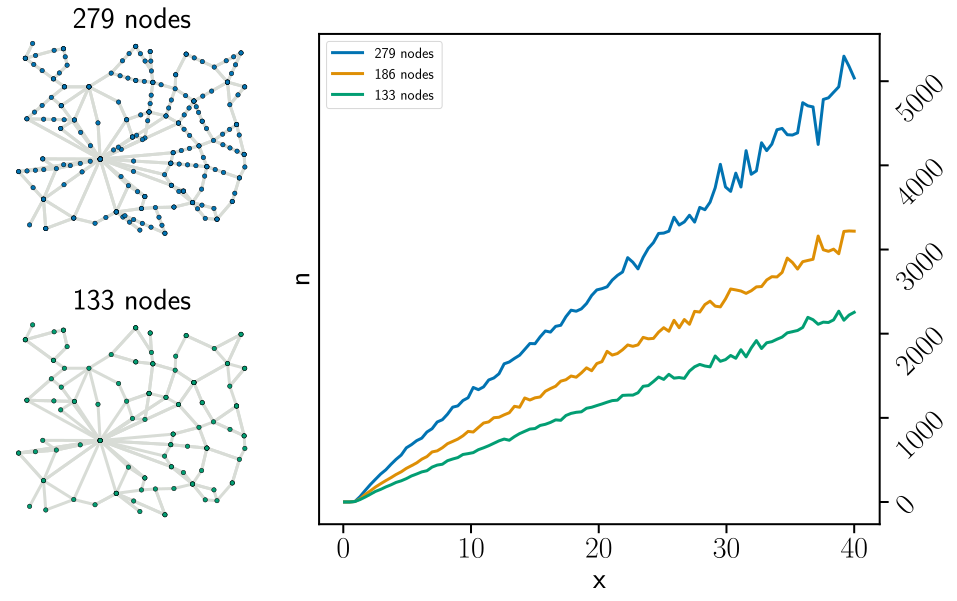

In [7]:
fig = plt.figure(figsize=(14,12))

ax2 = plt.subplot2grid((3, 3), (0, 0), fig=fig)
ax3 = plt.subplot2grid((3, 3), (1, 0), fig=fig)
ax1 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=2, fig=fig)

lines = dict()

for (coarse_graining_meters, target_edge_length), result in results.items():
    
    # load the graph
    _,G = all_Gs[coarse_graining_meters][target_edge_length]
    
    x_range = sorted(result.keys())
    
    n_arr = []

    for i in x_range:
        # compute n
        ins_df = pd.DataFrame(result[i]['insertion_data'], 
                              columns = INS_DATA_COLUMNS)
        n = np.median(ins_df['stoplist_len'])
    
        n_arr.append(n)
    
    l = ax1.plot(x_range, n_arr, label=f"{G.number_of_nodes()} nodes", linewidth=3)
    lines[(coarse_graining_meters, target_edge_length)] = l
    
ax1.legend(fontsize=15)
ax1.set_xlabel("x")
ax1.set_ylabel("n")

# draw some sample networks
for (coarse_graining_meters, target_edge_length), ax in zip([(200, 400), (200, 800)], (ax2, ax3)):
    _, G = all_Gs[coarse_graining_meters][target_edge_length]
    draw_network(G, ax=ax, title=f'{G.number_of_nodes()} nodes', node_color=[lines[(coarse_graining_meters, target_edge_length)][0].get_color()])
# aesthetics
ax1.yaxis.tick_right()
ax1.yaxis.set_tick_params(rotation=45)

fig.tight_layout(h_pad=0.1)
fig.savefig('many_berlins.pdf', bbox_inches='tight')